In [1]:
from brian2 import *

prefs.codegen.target = "numpy"

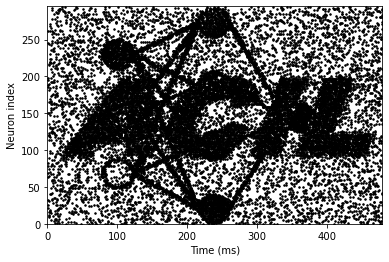

In [10]:
start_scope()
from matplotlib.image import imread
img = (1-imread('assets/acil_bw.png'))[::-1, :, 0].T
num_samples, N = img.shape
ta = TimedArray(img, dt=1*ms) # 228
A = 1.5
tau = 2*ms
eqs = '''
dv/dt = (A*ta(t, i)-v)/tau+0.8*xi*tau**-0.5 : 1
'''
G = NeuronGroup(
    N,
    eqs,
    threshold='v>1',
    reset='v=0',
    # refractory=15*ms,
    method='euler'
)
M = SpikeMonitor(G)

S = Synapses(G, G, 'w : 1')
S.connect(condition='i!=j')
S.w = '-1'

S2 = Synapses(G, G, 'w : 1')
S2.connect(condition='i==j')
S2.w = '1'

# scatter(S.x_pre/um, S.x_post/um, S.w*20)
# xlabel('Source neuron position (um)')
# ylabel('Target neuron position (um)');

run(num_samples*ms)
plot(M.t/ms, M.i, '.k', ms=3)
xlim(0, num_samples)
ylim(0, N)
xlabel('Time (ms)')
ylabel('Neuron index');

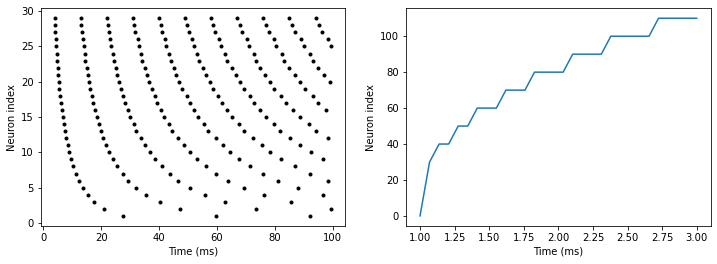

In [46]:
start_scope()

duration = 100 * ms
dim = 30

input_sample = linspace(1, 3, dim)
tau = 10*ms
# v0_max = 3.

# Input neurons
eqs_input = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

F0 = NeuronGroup(dim, eqs_input, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
M = SpikeMonitor(F0)

# F1.v0 = 'i*v0_max/(N-1)'
F0.v0 = input_sample

# eqs_input = '''
# dv/dt = 0 / tau : 1
# '''

# F0 = NeuronGroup(
#     dim,
#     eqs_input,
#     method='exponential_euler'
# )
# F0.v = input_sample

# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
# The model
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''

F1 = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
F1.v = El
statemon = StateMonitor(F1, 'v', record=True)
spikemon = SpikeMonitor(F1, variables='v')

# F0 to F1 connections
S0 = Synapses(F0, F1, 'w : 1')
S.connect(condition='i==j')
S.w = '50'

# F1 connections
S = Synapses(F1, F1, 'w : 1')
S.connect(condition='i!=j')
S.w = '-0.5'
S2 = Synapses(F1, F1, 'w : 1')
S2.connect(condition='i==j')
S2.w = '0.5'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(F0.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');


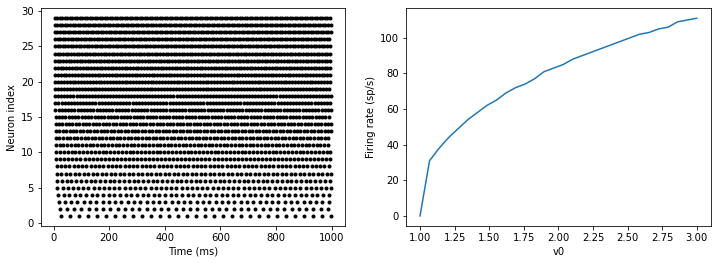

In [100]:
start_scope()

duration = 100 * ms
dim = 30

# ----------------------------------------
# F0
# ----------------------------------------

input_sample = linspace(1, 3, dim)
tau = 10*ms
# v0_max = 3.

# Input neurons
eqs_input = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

F0 = NeuronGroup(dim, eqs_input, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
M = SpikeMonitor(F0)

# F1.v0 = 'i*v0_max/(N-1)'
F0.v0 = input_sample

# ----------------------------------------
# F1
# ----------------------------------------

duration = 1*second
tau = 10*ms
eqs = '''
dv/dt = (v0 - v) / tau : volt (unless refractory)
v0 : volt
'''
F1 = NeuronGroup(dim, eqs, threshold='v > 10*mV', reset='v = 0*mV',
                    refractory=5*ms, method='exact')
F1.v = 0*mV
F1.v0 = '20*mV * i / (n-1)'

statemon = StateMonitor(F1, 'v', record=True)
spikemon = SpikeMonitor(F1, variables='v')

# F0 to F1 connections
S01 = Synapses(F0, F1, 'w : volt', on_pre='v_post += w')
S01.connect(condition='i==j')
S01.w = '5 * mV'

# F1 connections
S111 = Synapses(F1, F1, 'w : volt', on_pre='v_post += w')
S111.connect(condition='i!=j')
S111.w = '-1 * mV'
S112 = Synapses(F1, F1, 'w : volt', on_pre='v_post += w')
S112.connect(condition='i==j')
S112.w = '1 * mV'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(F0.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');



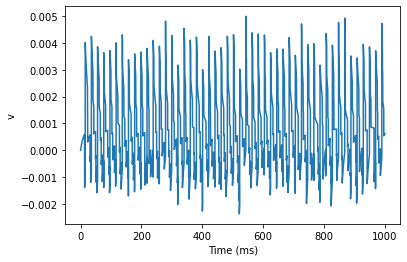

In [101]:
plot(statemon.t/ms, statemon.v[4])
xlabel('Time (ms)')
ylabel('v');

Text(0, 0.5, 'Firing rate (sp/s)')

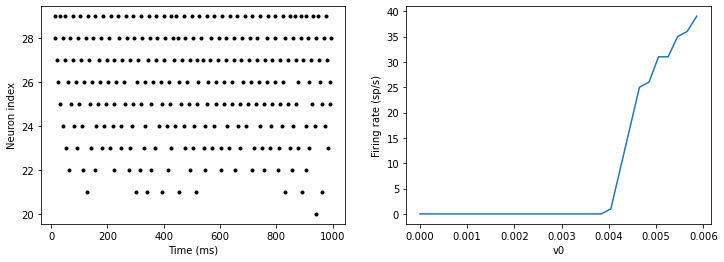

In [102]:
figure(figsize=(12,4))
subplot(121)
plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(F1.v0, spikemon.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');


WARNING    "tau" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


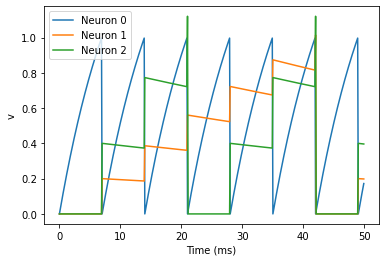

In [70]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

In [ ]:
start_scope()

duration = 100 * ms
dim = 30

# ----------------------------------------
# F0
# ----------------------------------------

input_sample = linspace(1, 3, dim)
tau = 10*ms
# v0_max = 3.

# Input neurons
eqs_input = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

F0 = NeuronGroup(dim, eqs_input, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
M = SpikeMonitor(F0)

# F1.v0 = 'i*v0_max/(N-1)'
F0.v0 = input_sample

# ----------------------------------------
# F1
# ----------------------------------------

duration = 1*second
tau = 10*ms
eqs = '''
dv/dt = (v0 - v) / tau : volt (unless refractory)
v0 : volt
'''
F1 = NeuronGroup(dim, eqs, threshold='v > 10*mV', reset='v = 0*mV',
                    refractory=5*ms, method='exact')
F1.v = 0*mV
F1.v0 = '20*mV * i / (n-1)'

statemon = StateMonitor(F1, 'v', record=True)
spikemon = SpikeMonitor(F1, variables='v')

# F0 to F1 connections
S01 = Synapses(F0, F1, 'w : volt', on_pre='v_post += w')
S01.connect(condition='i==j')
S01.w = '5 * mV'

# F1 connections
S111 = Synapses(F1, F1, 'w : volt', on_pre='v_post += w')
S111.connect(condition='i!=j')
S111.w = '-1 * mV'
S112 = Synapses(F1, F1, 'w : volt', on_pre='v_post += w')
S112.connect(condition='i==j')
S112.w = '1 * mV'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(F0.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');



WARNING    "statemonitor_3" has been included in the network but not the object on which it depends.Setting "statemonitor_3" to inactive. [brian2.core.magic.dependency_warning]


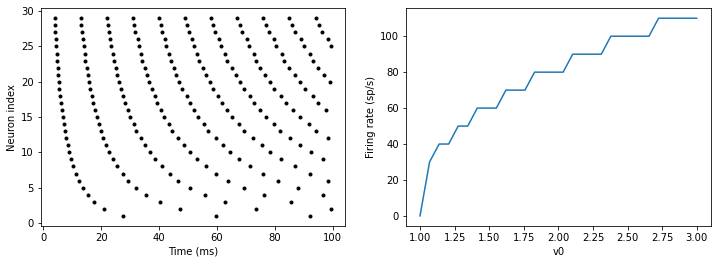

In [131]:
def lfp_field(num_neurons):
    # num_neurons = 100
    # duration = 2*second

    # Parameters
    area = 20000*umetre**2
    Cm = 1*ufarad*cm**-2 * area
    gl = 5e-5*siemens*cm**-2 * area
    El = -65*mV
    EK = -90*mV
    ENa = 50*mV
    g_na = 100*msiemens*cm**-2 * area
    g_kd = 30*msiemens*cm**-2 * area
    VT = -63*mV

    # The model
    eqs = Equations('''
    dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
    dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
    dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
    dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
    I : amp
    ''')
    # Threshold and refractoriness are only used for spike counting
    group = NeuronGroup(num_neurons, eqs,
                        threshold='v > -40*mV',
                        refractory='v > -40*mV',
                        method='exponential_euler')
    group.v = El
    # group.I = '0.7*nA * i / num_neurons'
    group.I = '0*nA'
    
    statemon = StateMonitor(group, 'v', record=True)
    spikemon = SpikeMonitor(group)

    # run(duration)

    # plot(group.I/nA, monitor.count / duration)
    # xlabel('I (nA)')
    # ylabel('Firing rate (sp/s)')
    # show()

    # plot(M.t/ms, M.v[20], label='Neuron 0')
    # # plot(M.t/ms, M.v[60], label='Neuron 1')
    # # plot(M.t/ms, M.v[70], label='Neuron 2')
    # xlabel('Time (ms)')
    # ylabel('v')
    # legend();
    return group, statemon, spikemon

# ----------------------------------------
# F0
# ----------------------------------------
def input_field(dim):
    input_sample = linspace(1, 3, dim)
    tau = 10*ms
    eqs_input = '''
    dv/dt = (v0-v)/tau : 1 (unless refractory)
    v0 : 1
    '''
    F0 = NeuronGroup(dim, eqs_input, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
    statemon = StateMonitor(group, 'v', record=True)
    spikemon = SpikeMonitor(F0)
    F0.v0 = input_sample

    return F0, statemon, spikemon

start_scope()

duration = 100 * ms
dim = 30

F0, statemon_0, spikemon_0 = input_field(dim)
F1, statemon_1, spikemon_1 = lfp_field(dim)

# F0 to F1 connections
S01 = Synapses(F0, F1, 'w : volt', on_pre='v_post += w')
S01.connect(condition='i==j')
S01.w = '5 * mV'

# F1 connections
S111 = Synapses(F1, F1, 'w : volt', on_pre='v_post += w')
S111.connect(condition='i!=j')
S111.w = '-rand() * 10 * mV'
S112 = Synapses(F1, F1, 'w : volt', on_pre='v_post += w')
S112.connect(condition='i==j')
S112.w = 'rand() * 40 * mV'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(spikemon_0.t/ms, spikemon_0.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(F0.v0, spikemon_0.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

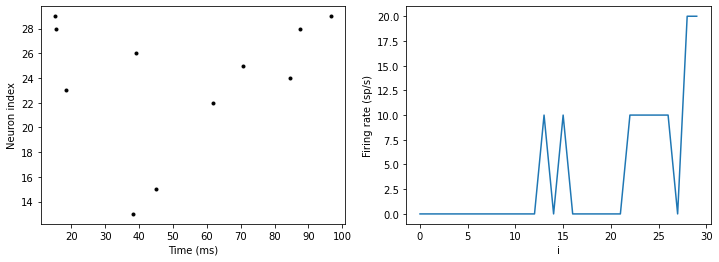

In [132]:
figure(figsize=(12,4))
subplot(121)
plot(spikemon_1.t/ms, spikemon_1.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(F1.i, spikemon_1.count/duration)
xlabel('i')
ylabel('Firing rate (sp/s)');